In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 讀取指數數據檔案
TXF_DATA = pd.read_excel('台指近月期貨指數.xlsx')
TXF_DATA['日期'] = pd.to_datetime(TXF_DATA['日期'])
TXF_DATA['EMA_20'] = TXF_DATA['收盤價'].ewm(span=20, adjust=False).mean()
TXF_DATA['Prev_Close'] = TXF_DATA['收盤價'].shift(1)
TXF_DATA['TR'] = TXF_DATA[['最高價', '最低價', 'Prev_Close']].apply(lambda x: max(x['最高價'] - x['最低價'],
                                                                abs(x['最高價'] - x['Prev_Close']), 
                                                                abs(x['最低價'] - x['Prev_Close'])),axis=1)
TXF_DATA['ATR'] = TXF_DATA['TR'].rolling(window=20).mean()
TXF_DATA['上軌'] = TXF_DATA['EMA_20'] + 2 * TXF_DATA['ATR']
TXF_DATA['下軌'] = TXF_DATA['EMA_20'] - 1 * TXF_DATA['ATR']
TXF_DATA = TXF_DATA.rename(columns={'開盤價':'Open','最高價': 'High', '最低價': 'Low','收盤價':'Close'})
TXF_DATA.set_index('日期', inplace=True)
TXF_DATA.head(5)

,期貨名稱,簡稱,Open,High,Low,Close,報酬率,成交張數(量),未平倉合約數,基差,未沖銷契約數(合計),EMA_20,Prev_Close,TR,ATR,上軌,下軌
日期,,,,,,,,,,,,,,,,,
1998-07-21,ZTXA,台指近月期貨指數,8131,8131,8036,8045,NaN,208,137,-95.80,140,8045.000000,NaN,95.0,NaN,NaN,NaN
1998-07-22,ZTXA,台指近月期貨指數,7950,7950,7820,7870,-0.021753,360,279,11.06,288,8028.333333,8045.0,225.0,NaN,NaN,NaN
1998-07-23,ZTXA,台指近月期貨指數,7830,7859,7802,7825,-0.005718,190,357,54.89,371,8008.968254,7870.0,68.0,NaN,NaN,NaN
1998-07-24,ZTXA,台指近月期貨指數,7750,7835,7740,7835,0.001278,340,420,67.40,443,7992.399849,7825.0,95.0,NaN,NaN,NaN
1998-07-27,ZTXA,台指近月期貨指數,7830,7835,7780,7786,-0.006254,150,466,104.30,493,7972.742720,7835.0,55.0,NaN,NaN,NaN


In [3]:
# 讀取結算日數據檔案
monthly_settlement_df = pd.read_excel('settlementDate.xlsx')
monthly_settlement_df = monthly_settlement_df[monthly_settlement_df["契約\n月份"].str.contains("W") == False].sort_values(by='結算日',ascending=True)
monthly_settlement_df['結算日'] = pd.to_datetime(monthly_settlement_df['結算日'])
monthly_settlement_df.rename(columns={'結算日': '日期','契約\n月份':'契約到期月份',
                                      '臺股期貨/小型臺指期貨/微型臺指期貨\n（ TX/MTX/TMF ）':'結算價'}, inplace=True)
monthly_settlement_df['該月結算日'] = 1
monthly_settlement_df.set_index('日期', inplace=True)
monthly_settlement_df.head(5)

,契約到期月份,結算價,該月結算日
日期,,,
1998-09-17,199809,7036,1
1998-10-22,199810,7068,1
1998-11-19,199811,7185,1
1998-12-17,199812,6695,1
1999-01-21,199901,6332,1


In [4]:
# 讀取保證金數據檔案
margin_money_df = pd.read_excel('台指期保證金.xlsx')
margin_money_df.set_index('日期', inplace=True)
margin_money_df = margin_money_df.rename(columns={'保證金':'原始保證金'})
margin_money_df.head(5)

,原始保證金
日期,
1998-07-21,140000
1998-08-19,120000
1999-01-06,150000
1999-01-19,140000
1999-01-29,120000


In [5]:
#合併三個dataframe
df = pd.concat([TXF_DATA, monthly_settlement_df, margin_money_df], axis=1)
#只針對'原始保證金'這個column的缺失值進行補充
df['原始保證金'] = df['原始保證金'].fillna(method='ffill')
# 將不是結算日的天數設為 0
df['該月結算日'] = df['該月結算日'].fillna(0).astype(int)
df.loc[df['結算價'].notna(), 'Close'] = df['結算價']
df = df.drop(columns=['簡稱','成交張數(量)','報酬率','基差','未沖銷契約數(合計)','High', '未平倉合約數','Low','結算價','契約到期月份'])
df=df.dropna()

C:\Users\user\AppData\Local\Temp\ipykernel_10000\482945969.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['原始保證金'] = df['原始保證金'].fillna(method='ffill')


In [6]:
df

,期貨名稱,Open,Close,EMA_20,Prev_Close,TR,ATR,上軌,下軌,該月結算日,原始保證金
日期,,,,,,,,,,,
1998-08-14,ZTXA,7275.0,7320.0,7562.580910,7291.0,186.0,94.65,7751.880910,7467.930910,0,140000.0
1998-08-15,ZTXA,7261.0,7300.0,7537.573204,7320.0,77.0,93.75,7725.073204,7443.823204,0,140000.0
1998-08-17,ZTXA,7285.0,7219.0,7507.232899,7300.0,81.0,86.55,7680.332899,7420.682899,0,140000.0
1998-08-18,ZTXA,7250.0,7220.0,7479.877385,7219.0,85.0,87.40,7654.677385,7392.477385,0,140000.0
1998-08-19,ZTXA,7269.0,7285.0,7461.317634,7220.0,80.0,86.65,7634.617634,7374.667634,0,120000.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-02,ZTXA,22838.0,22831.0,22541.504149,22991.0,276.0,313.50,23168.504149,22228.004149,0,241000.0
2024-07-03,ZTXA,23073.0,23185.0,22602.789469,22831.0,357.0,312.85,23228.489469,22289.939469,0,241000.0
2024-07-04,ZTXA,23487.0,23624.0,22700.047614,23185.0,441.0,321.55,23343.147614,22378.497614,0,241000.0


In [7]:
position = None              #原本持倉狀態
Buy_and_Hold = []            #紀錄買進持有的時間點
Sell_and_Short = []          #紀錄賣出放空的時間點
profit_list = []             #紀錄每天的獲利狀況
executesize = 1              #固定只買進一口
total_profit = 0             #總獲利狀態(剛開始為0)
total_cost = 0
cumulative_profit = []       #紀錄累積獲利
cumulative_profit_dates = [] #紀錄日期
each_day_profit = []
each_day_revenue = []

for i in range(len(df)):
    if i == len(df) - 1:
        break

    previous_total_profit = total_profit  # 記錄更新前的 total_profit

    if position is None:
        profit_list.append(0)
        
        # 本身平倉日就不能買
        if df['該月結算日'].iloc[i] == 1:
            position = None
            continue

        # 收盤價大於上軌，多單入場
        elif (df['Close'].iloc[i] > df['上軌'].iloc[i]) and df['該月結算日'].iloc[i] == 0:
            buy_price = df['Open'].iloc[i+1]
            profit = executesize * (df['Close'].iloc[i+1] - buy_price) * 200 * (1-0.00002)
            profit_list.append(profit)
            total_profit += profit
            total_cost += df['原始保證金'].iloc[i+1]
            position = 'Buy_and_Hold'
            Buy_and_Hold.append(i+1)
            continue

        # 收盤價小於下軌，空單入場
        elif (df['Close'].iloc[i] < df['下軌'].iloc[i]) and df['該月結算日'].iloc[i] == 0:
            buy_price = df['Open'].iloc[i+1]
            profit = executesize * (buy_price - df['Close'].iloc[i+1]) * 200 * (1-0.00002)
            profit_list.append(profit)
            total_profit += profit
            total_cost += df['原始保證金'].iloc[i+1]
            position = 'Sell_and_Short'
            Sell_and_Short.append(i+1)
            continue

    # 今天交易部位是買進持有的話
    elif position == 'Buy_and_Hold':
        # 停損點
        if (df['Close'].iloc[i] < df['下軌'].iloc[i]) and (df['該月結算日'].iloc[i+1] == 0):
            profit = executesize * (df['Close'].iloc[i+1] - df['Close'].iloc[i]) * 200 * (1-0.00002)
            profit_list.append(profit)
            total_profit += profit
            position = None
        
        # 該平倉了
        elif df['該月結算日'].iloc[i+1] == 1:
            profit = executesize * (df['Close'].iloc[i+1] - df['Close'].iloc[i]) * 200 * (1-0.00002)
            profit_list.append(profit)
            total_profit += profit
            position = None

    # 今天交易部位是賣出放空的話
    elif position == 'Sell_and_Short':
        # 停損點
        if (df['Close'].iloc[i] > df['上軌'].iloc[i]) and df['該月結算日'].iloc[i+1] == 0:
            profit = executesize * (df['Close'].iloc[i+1] - df['Close'].iloc[i]) * 200 * (1-0.00002)
            profit_list.append(profit)
            total_profit += profit
        
        # 該平倉了
        elif df['該月結算日'].iloc[i+1] == 1:
            profit = executesize * (df['Close'].iloc[i+1] - df['Close'].iloc[i]) * 200 * (1-0.00002)
            profit_list.append(profit)
            total_profit += profit
            position = None

    # 只有在 total_profit 變化的情況下才更新累積獲利列表
    if total_profit != previous_total_profit:
        cumulative_profit_dates.append(df.index[i])
        cumulative_profit.append(total_profit)
        each_day_profit.append(profit)


In [8]:
print("總獲利", total_profit)
print("總成本", total_cost)
# print("每天的獲利狀況",profit_list)
# print("買進持有的時間點:", Buy_and_Hold)
# print("累積獲利日期狀況",cumulative_profit_dates)
# print("累積獲利狀況",cumulative_profit)
# print("每日獲利狀況",each_day_profit)

總獲利 1605767.884
總成本 34744000.0


In [9]:
results_df = pd.DataFrame({
    '日期': cumulative_profit_dates,      
    '每日損益資金(元)': each_day_profit           
})
results_df.to_excel('每日損益紀錄.xlsx', index=False)  

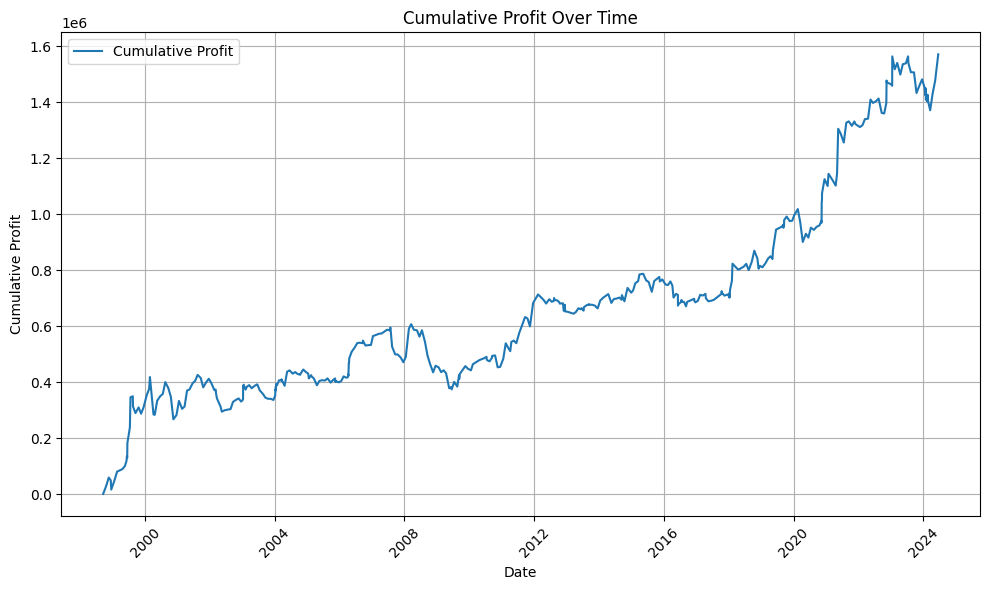

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_profit_dates, cumulative_profit, label='Cumulative Profit')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()